In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load pretrained model and test data

In [2]:
dict_genres = {'Electronic':0, 'Rock':1, 'Instrumental':2, 'Folk':3}

In [3]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(400, 640, 128) (400,)


In [5]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 3 1.5


In [6]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)
# X_test = np.expand_dims(X_test, axis = -1)
print(X_test.shape)

(400, 640, 128)


### Extract embeddings from the concat layer of the model

In [7]:
layer_name = 'dense1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [8]:
print(intermediate_output.shape)

(400, 64)


In [9]:
# print(intermediate_output[:2])

### Cluster using K means

In [9]:
from sklearn.cluster import KMeans, SpectralClustering

In [13]:
kmeans = KMeans(n_clusters=4, init='random', verbose =1).fit(intermediate_output)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2951.7695
start iteration
done sorting
end inner loop
Iteration 1, inertia 2567.9106
start iteration
done sorting
end inner loop
Iteration 2, inertia 2455.2427
start iteration
done sorting
end inner loop
Iteration 3, inertia 2110.6155
start iteration
done sorting
end inner loop
Iteration 4, inertia 1648.7604
start iteration
done sorting
end inner loop
Iteration 5, inertia 1573.329
start iteration
done sorting
end inner loop
Iteration 6, inertia 1556.9728
start iteration
done sorting
end inner loop
Iteration 7, inertia 1550.9817
start iteration
done sorting
end inner loop
Iteration 8, inertia 1548.4019
start iteration
done sorting
end inner loop
Iteration 9, inertia 1544.6755
start iteration
done sorting
end inner loop
Iteration 10, inertia 1543.3824
start iteration
done sorting
end inner loop
Iteration 11, inertia 1541.8892
start iteration
done sorting
end inner loop
Iteration 12, inertia 1540.5112

In [14]:
labels = kmeans.labels_
labels.shape

(400,)

In [15]:
print(labels)

[1 2 2 3 3 2 2 2 2 2 2 2 3 2 1 2 2 2 3 2 3 2 2 2 3 2 3 2 0 2 3 2 1 0 2 2 2
 2 2 0 0 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 0 3 2 2 2 0 0 2 2 2 1 3 1 1 1 1 1
 1 0 2 2 2 2 2 2 2 2 2 2 3 2 2 0 2 2 0 3 1 1 3 1 2 1 1 1 1 1 3 3 1 3 1 1 3
 2 1 1 1 1 1 1 2 2 3 3 2 2 1 2 2 2 2 3 2 2 0 2 2 1 1 2 1 1 1 1 1 1 1 0 2 1
 1 3 3 0 1 3 3 3 3 1 2 2 2 2 0 2 3 1 3 0 0 1 1 2 3 2 2 3 2 2 2 2 1 1 2 1 3
 3 3 3 3 2 1 3 2 2 1 1 1 3 1 1 1 1 2 1 1 1 3 3 2 1 3 3 3 3 3 2 3 3 1 0 1 2
 2 3 2 3 1 3 0 2 0 2 2 2 1 0 0 3 2 3 0 3 3 0 2 1 2 3 3 1 2 0 0 2 2 0 1 3 2
 2 1 3 1 1 1 1 1 1 1 1 2 1 3 3 2 2 3 0 2 2 2 2 2 1 2 2 3 3 2 2 2 2 2 3 1 0
 0 3 0 3 0 2 2 2 2 2 3 2 3 3 3 0 0 0 3 1 2 3 3 3 3 3 3 3 3 3 0 3 3 3 0 0 0
 3 2 2 0 3 2 2 3 2 0 0 3 1 0 2 2 2 0 2 1 3 3 3 2 3 2 3 2 2 2 0 2 2 2 2 0 1
 2 1 2 1 3 2 1 2 1 2 2 1 0 1 1 1 2 3 2 3 3 0 0 3 2 2 0 0 0 0]


### Evaluate the output from K-means 

#### Adjusted Rand Index

In [16]:
from sklearn.metrics import adjusted_rand_score

In [17]:
adjusted_rand_score(y_test, labels)

0.25628004667894627

#### Try different number of clusters

In [18]:
from sklearn.metrics import silhouette_score

for cluster in range(2,10):
    kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
    labels = kmeans.labels_
    score = silhouette_score(intermediate_output, labels, metric='euclidean')
    print("Cluster number and Score is: ", cluster, score)

Cluster number and Score is:  2 0.33993408
Cluster number and Score is:  3 0.3974991
Cluster number and Score is:  4 0.42788804
Cluster number and Score is:  5 0.4361174
Cluster number and Score is:  6 0.40759078
Cluster number and Score is:  7 0.37752396
Cluster number and Score is:  8 0.37492782
Cluster number and Score is:  9 0.33290946


### Visualizations

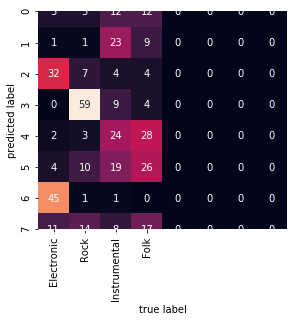

In [19]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 8
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');



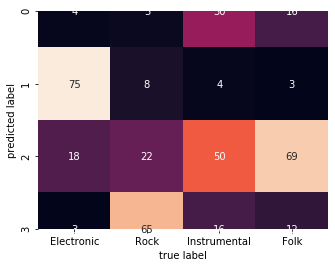

In [20]:
### 4 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 4
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

